In [1]:
import admix
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# specify parameters
n_indiv = 5000

In [8]:
# specify reference data sets
dset_dir = admix.dataset.get_test_data_dir()
ref_dset = admix.io.read_dataset(os.path.join(dset_dir, "toy-all"))
ref_dset_list = [
    ref_dset[:, (ref_dset.indiv.SuperPop == pop).values] for pop in ["EUR", "AFR"]
]

In [9]:
# simulate 8 generations
mosaic_size = admix.simulate.calculate_mosaic_size(
    ref_dset.snp, "hg38", chrom=22, n_gen=8
)

np.random.seed(1234)
dset = admix.simulate.admix_geno(
    geno_list=[dset.geno for dset in ref_dset_list],
    df_snp = ref_dset_list[0].snp,
    n_indiv=n_indiv,
    anc_props=[0.5, 0.5],
    mosaic_size=mosaic_size,
)

100%|██████████| 10000/10000 [00:00<00:00, 26624.16it/s]


/Users/kangchenghou/work/admix-kit/admix/plot/_plot.py:167: UserWarning: Only the first 10 are plotted. To plot more individuals, increase `max_indiv`
  warnings.warn(


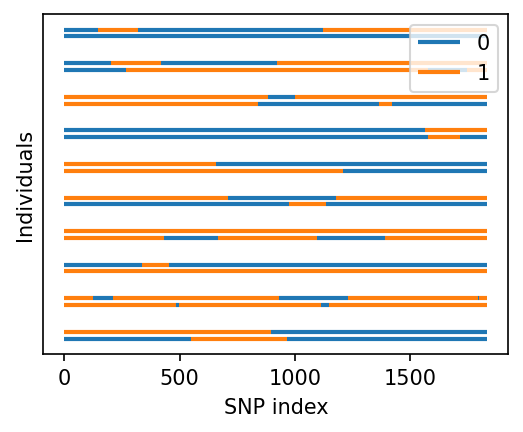

In [10]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
admix.plot.lanc(dset, ax=ax)

In [11]:
dset.snp[["EUR_FREQ", "AFR_FREQ"]] = dset.af_per_anc()

admix.data.af_per_anc: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


In [12]:
dset = dset[((dset.snp.EUR_FREQ.between(0.01, 0.99)) & (dset.snp.AFR_FREQ.between(0.01, 0.99))).values]

In [13]:
admix_ld = admix.data.admix_ld(dset)

In [20]:
def GG(admix_ld, i, j):
    ld1, ld2, ld12 = admix_ld["11"], admix_ld["22"], admix_ld["12"]
    return np.array([
        [ld1[i, j], ld12[i, j]],
        [ld12[j, i], ld2[i, j]]
    ])

In [21]:
dset

admix.Dataset object with n_snp x n_indiv = 1092 x 5000, n_anc=2
	snp: 'CHROM', 'POS', 'REF', 'ALT', 'EUR_FREQ', 'AFR_FREQ'

In [22]:
res = []
for i in range(dset.n_snp - 1):
    GiGj = GG(admix_ld, i, i + 1)
    GiGi = GG(admix_ld, i, i)
    tag = np.linalg.inv(GiGi) @ GiGj @ np.ones(2)[:, None]
    res.append(tag.T)
res = np.vstack(res)

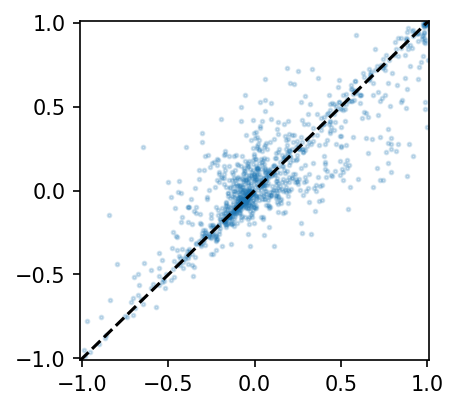

In [23]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(res[:, 0], res[:, 1], s=3, alpha=0.2)
lim = max(abs(res.max()), abs(res.min()))
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.plot((-lim, lim), (-lim, lim), 'k--')

In [24]:
res.mean(axis=0)

array([0.08930858, 0.09481761])

In [19]:
np.abs(res).mean(axis=0)

array([0.29269242, 0.30642844])